In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import gridspec
import matplotlib

In [2]:
vert_ds = xr.open_dataarray('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/vert_ds.nc')

vertcont_ds = xr.open_dataarray('~/a/processed_var_data/CMIP_ensmean_piControl_wap.nc')

In [3]:
sst_cont = xr.open_dataarray('~/a/processed_var_data/CMIP_sst_piControl_2x2_37memens.nc')
sst_cont.load()

sst_hist = xr.open_dataarray('~/a/processed_var_data/CMIP_sst_hist_2x2_37memens.nc')
sst_hist.load()

<xarray.DataArray 'ts' (name: 37, time: 1500, lat: 88, lon: 179)>
array([[[[245.1859862 , 245.05620307, 244.92043969, ..., 245.75533118,
          245.6111197 , 245.45203602],
         [245.88063364, 245.58245054, 245.37763481, ..., 247.19417147,
          246.82641607, 246.45907957],
         [248.01682291, 247.3577596 , 246.7102842 , ..., 250.3653935 ,
          249.80158043, 249.32374638],
         ...,
         [245.06593436, 245.39194295, 245.63474012, ..., 241.69775934,
          242.72476049, 243.74282717],
         [242.68845289, 243.00853387, 243.20048054, ..., 241.26501357,
          241.50763409, 241.96129718],
         [241.32728171, 241.53171362, 241.72946795, ..., 240.6040532 ,
          240.76747683, 240.98713307]],

        [[233.05632464, 232.91759595, 232.7670064 , ..., 233.7315024 ,
          233.52934174, 233.37129233],
         [233.43740169, 233.17238575, 232.67125688, ..., 235.19431216,
          234.55833563, 234.25745403],
         [237.49387496, 236.81338542, 236.08487523, ..., 239.89354951,
          239.37231635, 238.98301092],
...
         [253.5345807 , 253.62416859, 253.69687856, ..., 252.92499209,
          253.30769977, 253.40706583],
         [252.19553908, 252.21278911, 252.23002734, ..., 252.18424604,
          252.13351638, 252.15487338],
         [250.74838405, 250.75130838, 250.75423612, ..., 250.80454796,
          250.78808492, 250.7716162 ]],

        [[238.65758206, 238.53384663, 238.41010391, ..., 239.38124703,
          239.19216301, 239.00308465],
         [238.65255689, 238.40425581, 238.15596025, ..., 239.97529907,
          239.60325604, 239.27263674],
         [240.91002447, 240.37961032, 239.84836888, ..., 242.76911442,
          242.38854589, 241.9071123 ],
         ...,
         [248.88179831, 249.23645723, 249.55722985, ..., 247.64610281,
          247.93472235, 248.24773801],
         [248.91423681, 249.04374118, 249.17324417, ..., 248.24221544,
          248.36503936, 248.55882082],
         [248.6031107 , 248.60378665, 248.60446968, ..., 248.54380519,
          248.56065276, 248.5774984 ]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'IPSL-CM6A-LR' 'GISS-E2-1-G' ... 'EC-Earth3'
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         Surface temperature (skin for open ocean)
    history:             none
    interval_operation:  900 s
    interval_write:      1 month
    long_name:           Surface Temperature
    online_operation:    average
    standard_name:       surface_temperature
    units:               K

In [4]:
sst_cont_rolling = sst_cont.rolling(time=300, center=True).mean('time')
sst_cont_std = sst_cont_rolling.std('time')
sst_cont_var = sst_cont_std.mean('name')
sst_cont_var

<xarray.DataArray 'ts' (lat: 88, lon: 179)>
array([[0.18611056, 0.18548419, 0.18522849, ..., 0.18603225, 0.18324389,
        0.18514295],
       [0.19611045, 0.19556088, 0.19287411, ..., 0.19287646, 0.1920996 ,
        0.19303032],
       [0.20928829, 0.20550019, 0.20433981, ..., 0.20405629, 0.20499351,
        0.206187  ],
       ...,
       [0.38005681, 0.37939689, 0.388323  , ..., 0.33648883, 0.34295553,
        0.3522904 ],
       [0.34515087, 0.34028098, 0.34497288, ..., 0.32085442, 0.32468839,
        0.32942816],
       [0.3240933 , 0.31851821, 0.32001277, ..., 0.3143705 , 0.31460889,
        0.31540112]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

Text(0.5, 1.0, 'Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

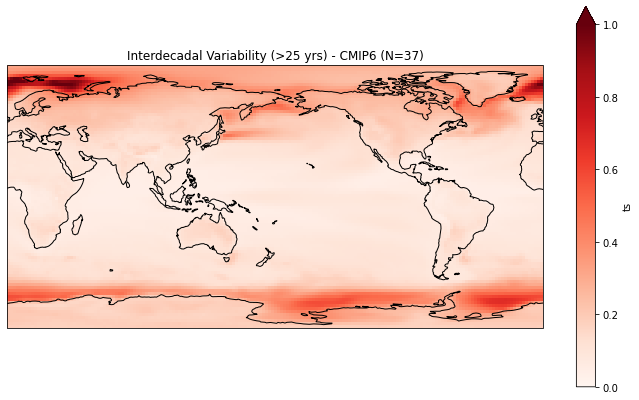

In [13]:
# 37 entries
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_cont_var.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)
plt.title('Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

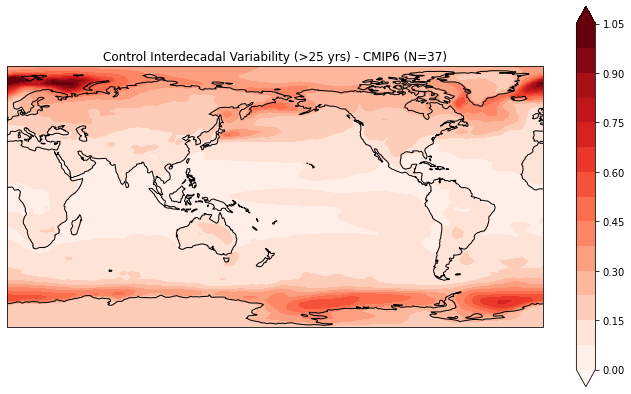

In [12]:
plt.rcParams['figure.figsize'] = [12, 7]
levels = [0,0.075,0.15,0.225,0.3,0.375,0.45,0.525,0.6,0.675,0.75,0.825,0.9,0.975,1.05]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.contourf(sst_cont_var.lon,sst_cont_var.lat,sst_cont_var, transform=ccrs.PlateCarree(), cmap='Reds', 
             vmin=0, vmax=1, levels=levels, extend='both')
ax.coastlines(color='black', linewidth=1)
plt.title('Control Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')
plt.colorbar()

In [5]:
sst_hist_rolling = sst_hist.rolling(time=300, center=True).mean('time')
sst_hist_std = sst_hist_rolling.std('time')
sst_hist_var = sst_hist_std.mean('name')
sst_hist_var

<xarray.DataArray 'ts' (lat: 88, lon: 179)>
array([[0.25679084, 0.28866793, 0.2889658 , ..., 0.28849665, 0.28944844,
        0.2902723 ],
       [0.26530623, 0.30028041, 0.29976371, ..., 0.29194822, 0.2920829 ,
        0.29491737],
       [0.2698167 , 0.2974619 , 0.30132567, ..., 0.28841363, 0.28904997,
        0.29218652],
       ...,
       [0.53551052, 0.55810739, 0.56886731, ..., 0.50487696, 0.51275742,
        0.5251616 ],
       [0.49983946, 0.5172754 , 0.52258341, ..., 0.49803276, 0.50077506,
        0.50690074],
       [0.4790128 , 0.49383401, 0.49572118, ..., 0.48821392, 0.4897505 ,
        0.49165765]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [6]:
sst_diff_var = sst_hist_var - sst_cont_var

sst_percent_var = sst_diff_var*100/sst_cont_var

Text(0.5, 1.0, 'Percentage Change in Interdecadal Variability (>25 yrs) - CMIP6 (N=15)')

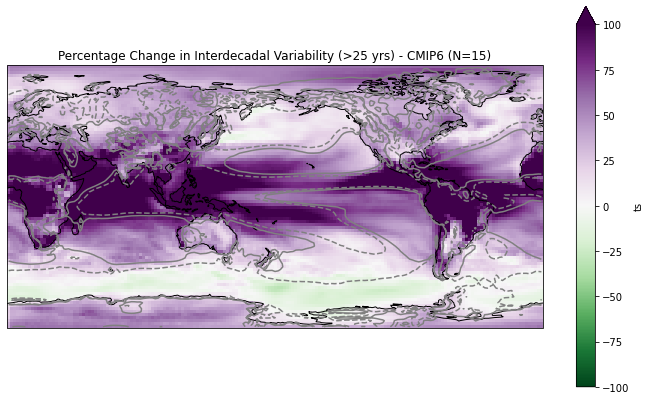

In [23]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_percent_var.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-100, vmax=100)
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Percentage Change in Interdecadal Variability (>25 yrs) - CMIP6 (N=15)')

# Scatter Plot building

In [7]:
colored_lats = []
for latitude in sst_cont_var['lat'].values:
    for i in range(179): #length of longitude
       colored_lats.append(latitude)
print(len(colored_lats))

15752


Text(0, 0.5, 'Variability')

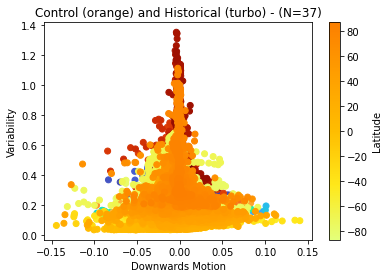

In [9]:
plt.scatter(vert_ds,sst_hist_var,c=colored_lats,cmap='turbo')
plt.scatter(vertcont_ds,sst_cont_var,c=colored_lats,cmap='Wistia')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Latitude')
plt.title('Control (orange) and Historical (turbo) - (N=37)')
plt.xlabel('Downwards Motion')
plt.ylabel('Variability')

# Figures

Text(0, 0.5, 'Percent change in TS variability [%]')

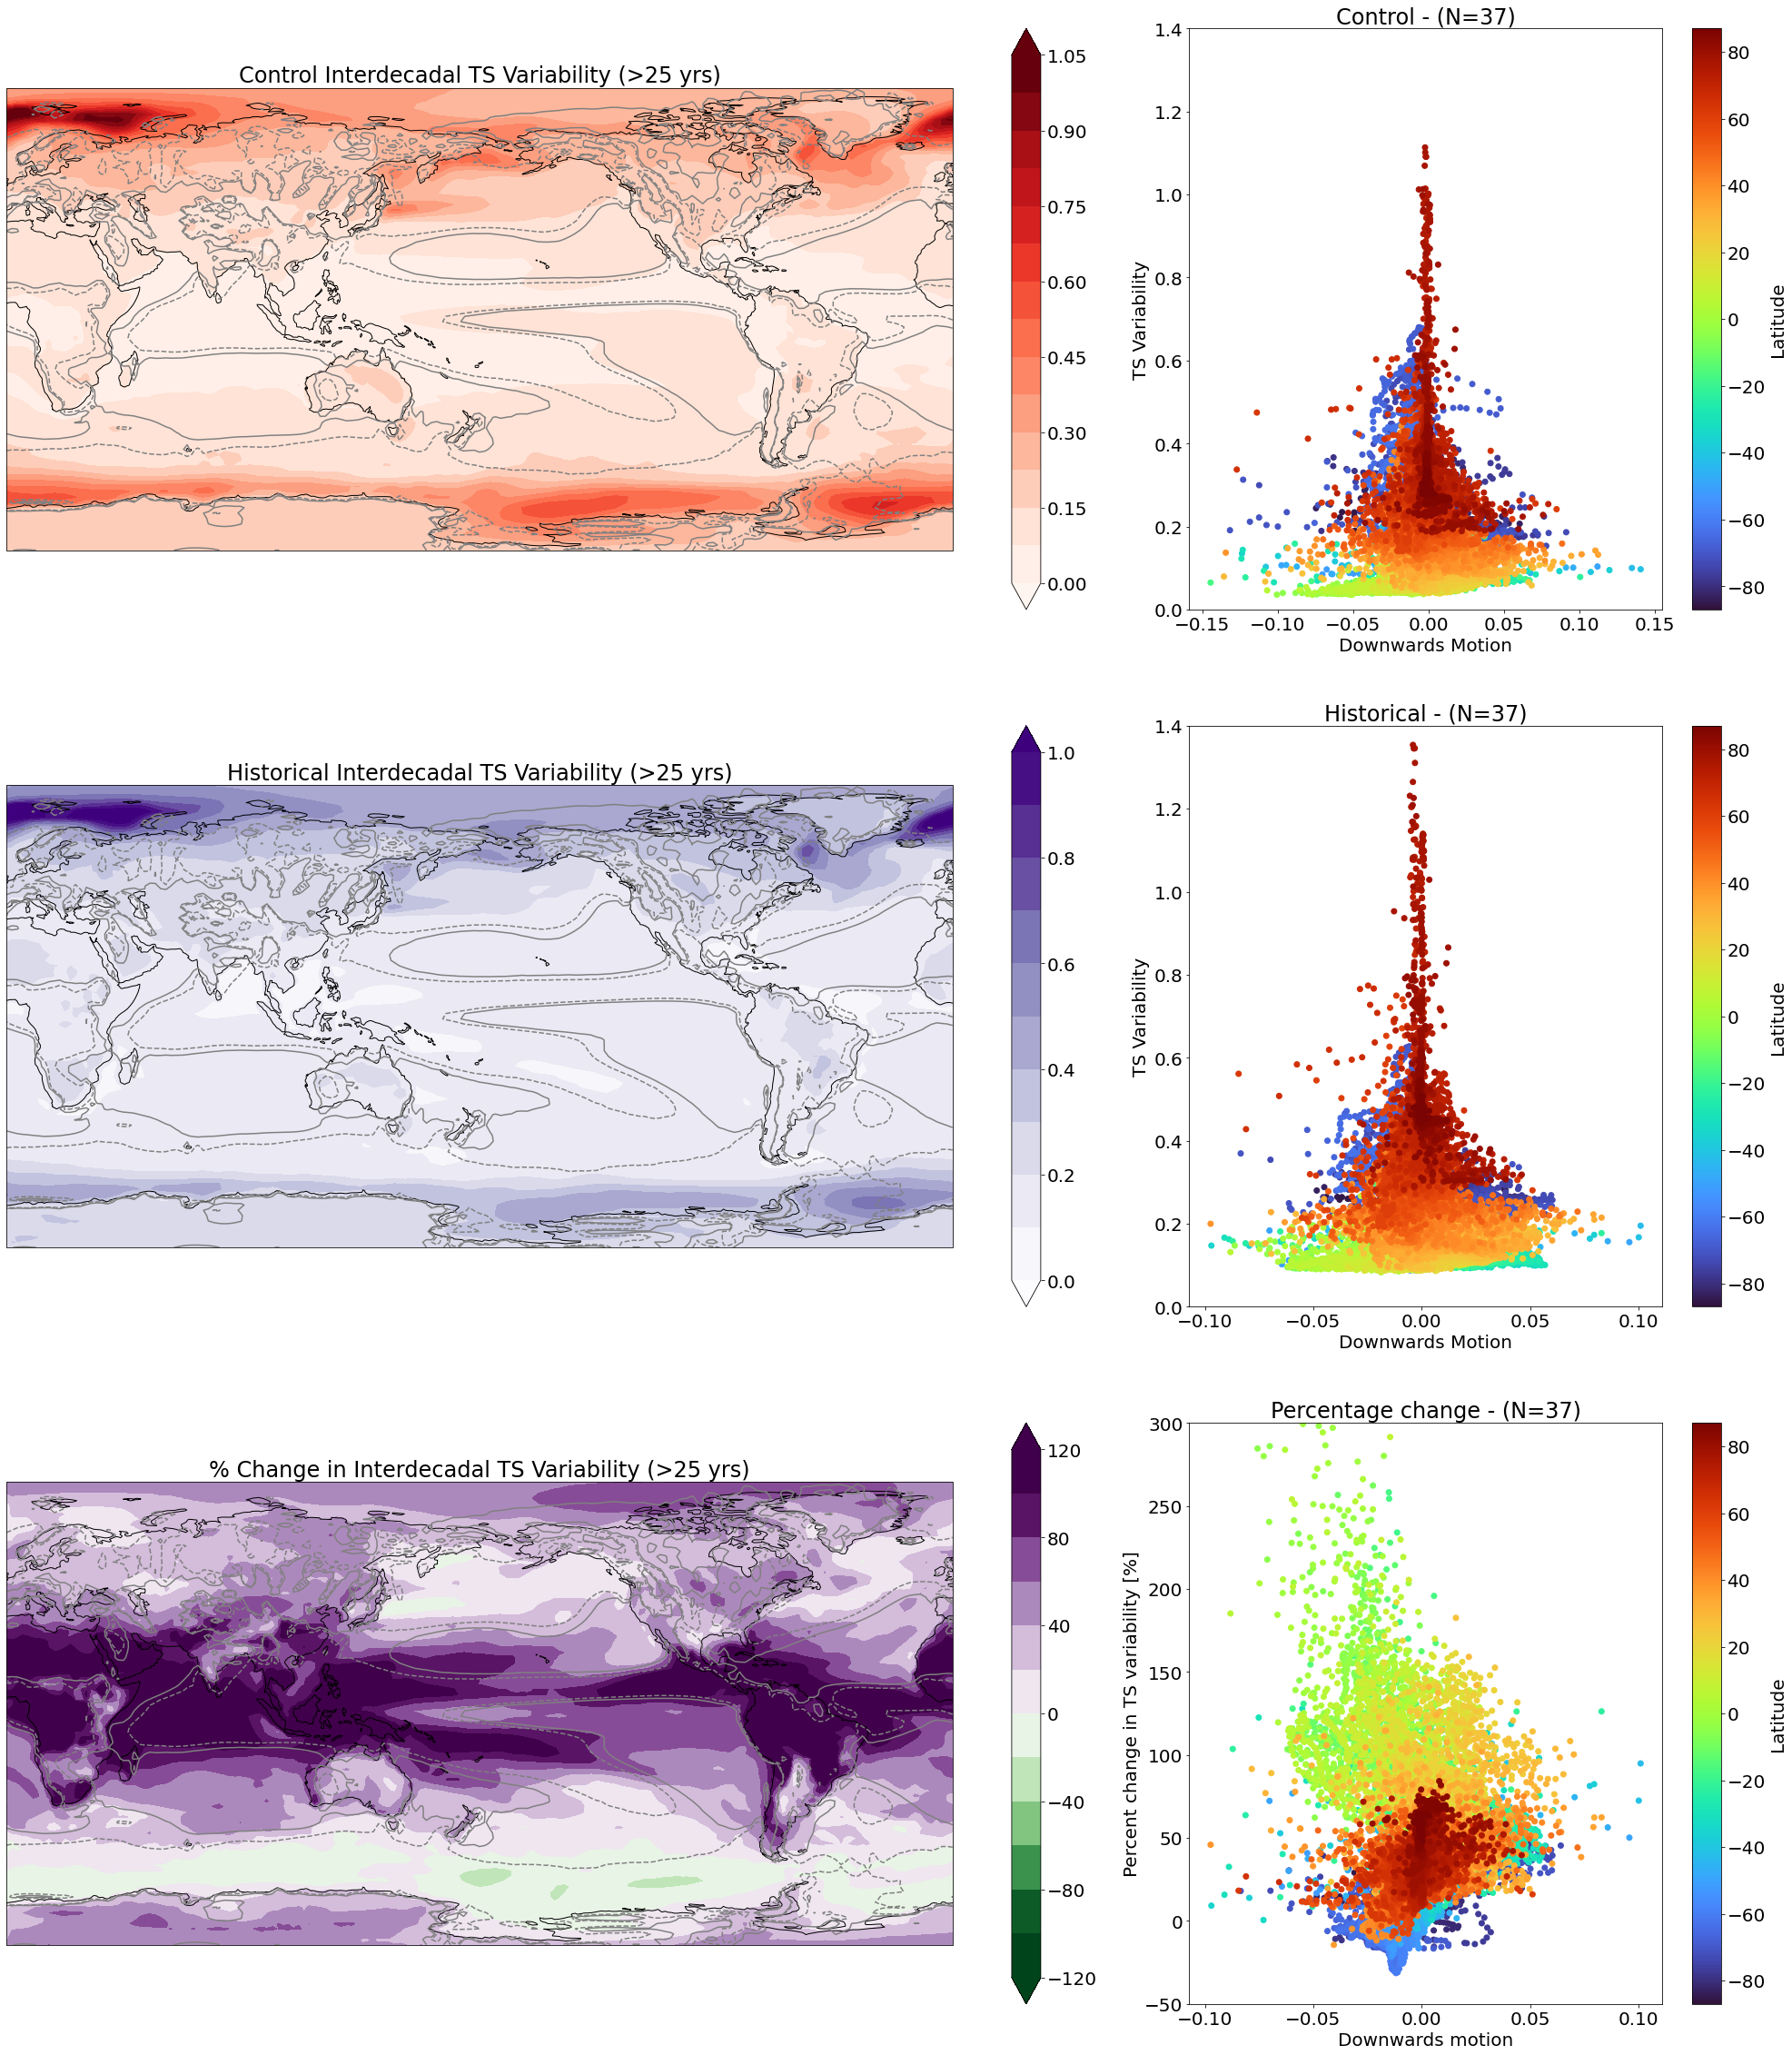

In [26]:
fig = plt.figure(figsize=(35, 40))
gs = gridspec.GridSpec(3, 2, width_ratios=[2,1])
gs.update(wspace=0)
#top=300
#bottom=270
font = {'size'   : 20,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
levels_cont = [0,0.075,0.15,0.225,0.3,0.375,0.45,0.525,0.6,0.675,0.75,0.825,0.9,0.975,1.05]
plt.contourf(sst_cont_var.lon,sst_cont_var.lat,sst_cont_var,transform=ccrs.PlateCarree(), 
             cmap='Reds', vmin=0, vmax=1, levels=levels_cont, extend='both')
ax1.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax1, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Control Interdecadal TS Variability (>25 yrs)')
plt.colorbar()

ax2 = fig.add_subplot(gs[1])
scatter = ax2.scatter(vertcont_ds,sst_cont_var,c=colored_lats,cmap='turbo')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.ax.set_ylabel('Latitude')
plt.title('Control - (N=37)')
plt.xlabel('Downwards Motion')
plt.ylim(0, 1.4)
plt.ylabel('TS Variability')

ax3 = fig.add_subplot(gs[2], projection=ccrs.PlateCarree(central_longitude=180))
levels_hist = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.contourf(sst_hist_var.lon,sst_hist_var.lat, sst_hist_var, transform=ccrs.PlateCarree(),
             cmap='Purples', vmin=0, vmax=1, levels=levels_hist, extend='both')
ax3.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax3, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Historical Interdecadal TS Variability (>25 yrs)')
plt.colorbar()

ax4 = fig.add_subplot(gs[3])
scatter_hist = ax4.scatter(vert_ds,sst_hist_var,c=colored_lats,cmap='turbo')
cbar = plt.colorbar(scatter_hist, ax=ax4)
cbar.ax.set_ylabel('Latitude')
plt.title('Historical - (N=37)')
plt.ylim(0,1.4)
plt.xlabel('Downwards Motion')
plt.ylabel('TS Variability')

ax5 = fig.add_subplot(gs[4], projection=ccrs.PlateCarree(central_longitude=180))
levels_percent = [-120,-100,-80,-60,-40,-20,0,20,40,60,80,100,120]
plt.contourf(sst_percent_var.lon,sst_percent_var.lat,sst_percent_var, transform=ccrs.PlateCarree(), 
             cmap='PRGn_r', vmin=-100, vmax=100, levels=levels_percent, extend='both')
ax5.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax5, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('% Change in Interdecadal TS Variability (>25 yrs)')
plt.colorbar()

ax6 = fig.add_subplot(gs[5])
scatter_percent = ax6.scatter(vert_ds, sst_percent_var, c=colored_lats, cmap='turbo')
cbar = plt.colorbar(scatter_hist, ax=ax6)
cbar.ax.set_ylabel('Latitude')
plt.ylim(-50,300)
plt.title('Percentage change - (N=37)')
plt.xlabel('Downwards motion')
plt.ylabel('Percent change in TS variability [%]')

# Testing